In [3]:
import subprocess
import os
import pandas as pd
#import netCDF4
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
import copy
import xarray as xr
from datetime import datetime, timedelta 
import dask
from scipy.interpolate import griddata
#from ocean_c_lab_tools import *
#from celluloid import Camera 
#import PyCO2SYS as csys
import seawater as sw
from roms_regrid import *

/tmp/ipykernel_1590548/3945946454.py:17: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [4]:
xls = pd.ExcelFile('/global/cfs/cdirs/m4632/uheede/Hafro_obsdata/20241210_biogeochemistry_format.xlsx')
combo = pd.read_excel(xls, 'Sheet1',decimal='.')


obs=xr.Dataset.from_dataframe(combo)
obs=obs.set_index(index=['HV','depth_bin','date'])
obs=obs.drop_duplicates('index')
obs=obs.unstack('index')
obs=obs.rename(name_dict={'Latitude(°N)':'lat','Longitude(°E)':'lon'})



In [5]:
density=sw.dens0(obs['S'],obs['T'])
obs['Alk']=obs['TA'] * (1 / 1000) * density
obs['DIC']=obs['DIC'] * (1 / 1000) * density

In [6]:
TA0=274
Sref=34
DIC0=315
nTA=((obs['Alk']-TA0)/obs['S'])*Sref+TA0

nDIC=((obs['DIC']-DIC0)/obs['S'])*Sref+DIC0

In [7]:
# define location which calculations the average location of each station
def get_location(obs, hv_values):
    locations = []
    for hv in hv_values:
        lat = (obs['lat'].sel(HV=hv).isel(depth_bin=0).mean('date').squeeze()).values+0
        lon = obs['lon'].sel(HV=hv).isel(depth_bin=0).mean('date').squeeze().values + 360
        locations.append([lat, lon])
    return locations

# List of HV values
hv_values = 1,3,5,7,9,10,12

# Get the locations
locations = get_location(obs, hv_values)

In [8]:

#x=xr.open_mfdataset('/pscratch/sd/u/uheede/from_expanse/Iceland3/*', combine='nested', concat_dim=["time"])

# open grid
grid=xr.open_mfdataset('/global/cfs/cdirs/m4632/uheede/roms_setups/Iceland3_MARBL/1.Make_grid/Iceland3_grd.nc')



# regridding
h=roms_regrid(grid,grid['h'])

mask=roms_regrid(grid,grid['mask_rho'])

;

''

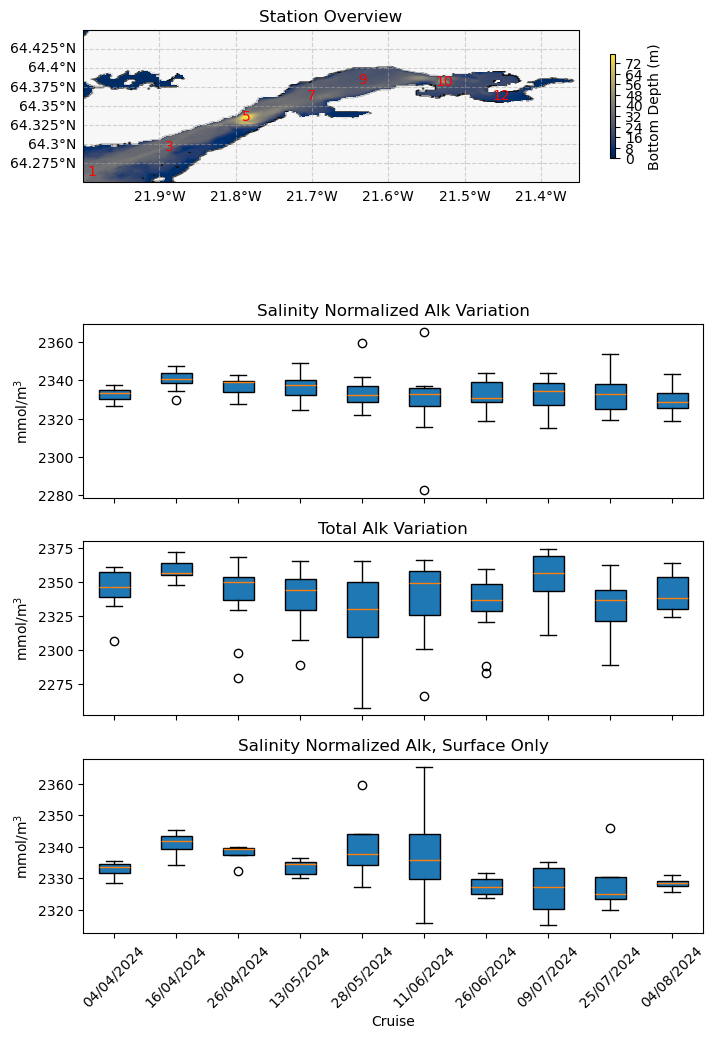

In [9]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define depth levels
levels = np.arange(0, 80)

# Create figure and subplots
fig = plt.figure(figsize=(8, 13))
gs = fig.add_gridspec(4, 1, height_ratios=[2, 1, 1, 1])

# Main map plot
ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

# Plot bathymetry
cf1 = ax.contourf(h.lon, h.lat, h, levels, transform=ccrs.PlateCarree(), cmap='cividis')
ax.contourf(h.lon, h.lat, mask.where(mask != 1), cmap='Greys', transform=ccrs.PlateCarree())

# Add station labels
for i, e in enumerate(locations):
    ax.text(e[1], e[0], hv_values[i], color='red', size=10, ha='center', va='center', transform=ccrs.PlateCarree())

# Gridlines
gls = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color='darkgray', alpha=0.5, linestyle='--')
gls.top_labels = False
gls.right_labels = False

# Colorbar
cb1 = plt.colorbar(cf1, shrink=0.3)
cb1.set_label('Bottom Depth (m)', fontsize=10)

ax.set_extent([-22, -21.35, 64.25, 64.45], ccrs.PlateCarree())
ax.set_title('Station Overview')

# --- Boxplot Data Preparation ---
def extract_cruise_data(var, depth=None, num_cruises=10):
    """Extracts non-NaN values for a given variable across cruises."""
    cruises = []
    for i in range(num_cruises):
        data = np.hstack(var.isel(date=i) if depth is None else var.isel(date=i, depth_bin=depth))
        cruises.append(data[~np.isnan(data)])
    return cruises

# --- Salinity Normalized DIC Variation ---
ax2.boxplot(extract_cruise_data(nTA), patch_artist=True)
ax2.set_title('Salinity Normalized Alk Variation')
ax2.set_ylabel('mmol/m$^3$')
ax2.set_xticklabels([])

# --- Total DIC Variation ---
ax3.boxplot(extract_cruise_data(obs['Alk']), patch_artist=True)
ax3.set_title('Total Alk Variation')
ax3.set_ylabel('mmol/m$^3$')
ax3.set_xticklabels([])

# --- Surface-Only Salinity Normalized DIC ---
ax4.boxplot(extract_cruise_data(nTA, depth=0), patch_artist=True)
ax4.set_title('Salinity Normalized Alk, Surface Only')
ax4.set_xlabel('Cruise')
ax4.set_ylabel('mmol/m$^3$')
ax4.set_xticklabels(pd.to_datetime(obs['date'].isel(date=slice(0,10))).strftime('%d/%m/%Y'), rotation=45)

plt.show()


Text(0, 0.5, 'depth (m)')

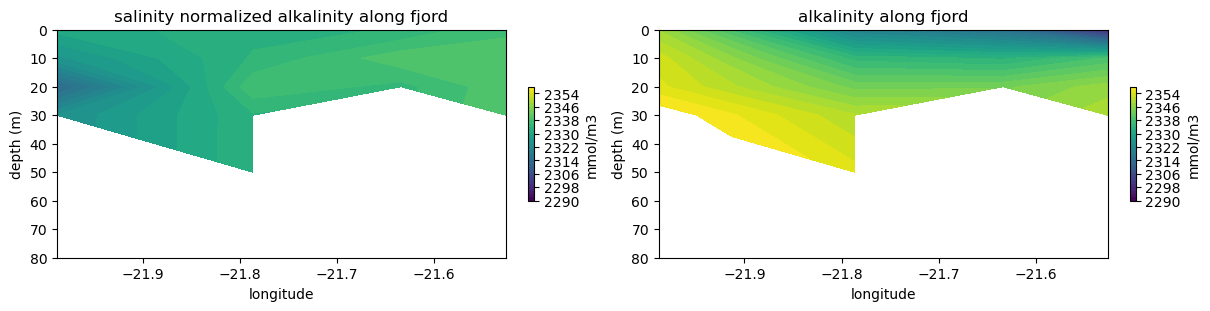

In [10]:
loc = obs['lon'].sel(HV=[1,5,9,10]).isel(depth_bin=0).mean('date').values
depth=obs['depth_bin'].values
levels=np.arange(2290,2360,2)

bins = np.arange(0, 90, 10) 
#depth_bins = xr.DataArray(pd.cut(depth, bins, labels=bins[:-1]), dims="depth", name="binned_depth")

data_alk1=nTA.sel(HV=[1,5,9,10]).isel(date=slice(0,9)).mean('date')
data_alk2=obs['Alk'].sel(HV=[1,5,9,10]).isel(date=slice(0,9)).mean('date')

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 3), constrained_layout=True)
ax = axarr.flatten()

#c0=ax[0].contourf(loc, data_alk.depth, data_alk.transpose())
c0=ax[0].contourf(loc,data_alk1.depth_bin,data_alk1.transpose(),levels)
plt.colorbar(c0,ax=ax[0], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[0].invert_yaxis()
ax[0].set_title('salinity normalized alkalinity along fjord')
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('depth (m)')

c0=ax[1].contourf(loc,data_alk2.depth_bin,data_alk2.transpose(),levels)
plt.colorbar(c0,ax=ax[1], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[1].invert_yaxis()
ax[1].set_title('alkalinity along fjord')
ax[1].set_xlabel('longitude')
ax[1].set_ylabel('depth (m)')

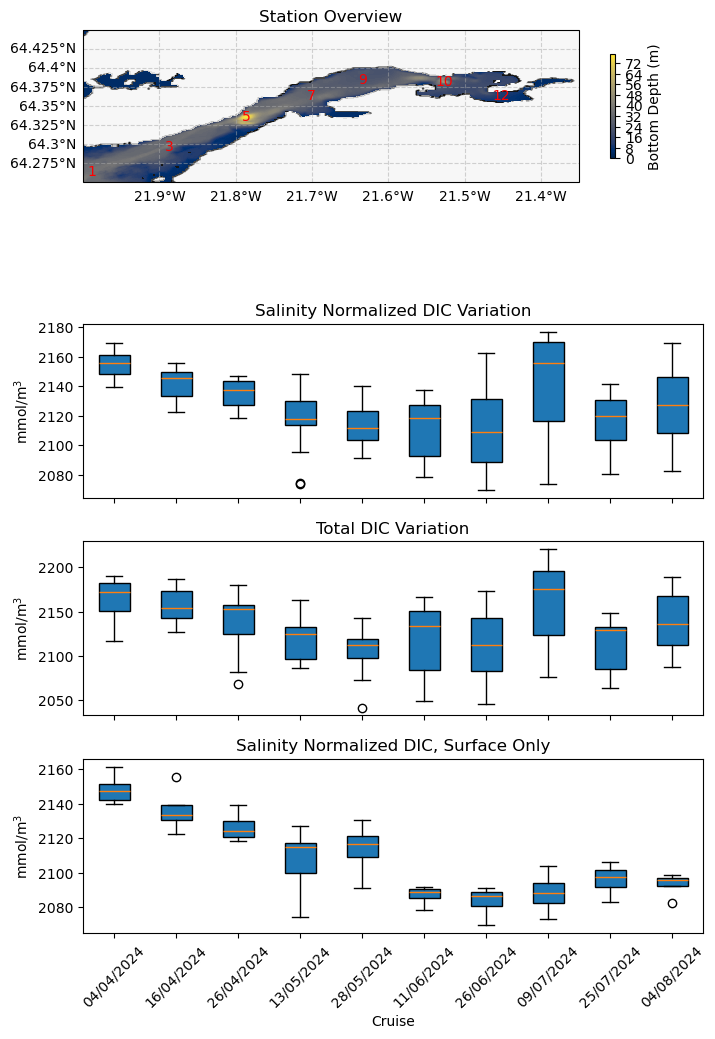

In [13]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define depth levels
levels = np.arange(0, 80)

# Create figure and subplots
fig = plt.figure(figsize=(8, 13))
gs = fig.add_gridspec(4, 1, height_ratios=[2, 1, 1, 1])

# Main map plot
ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

# Plot bathymetry
cf1 = ax.contourf(h.lon, h.lat, h, levels, transform=ccrs.PlateCarree(), cmap='cividis')
ax.contourf(h.lon, h.lat, mask.where(mask != 1), cmap='Greys', transform=ccrs.PlateCarree())

# Add station labels
for i, e in enumerate(locations):
    ax.text(e[1], e[0], hv_values[i], color='red', size=10, ha='center', va='center', transform=ccrs.PlateCarree())

# Gridlines
gls = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color='darkgray', alpha=0.5, linestyle='--')
gls.top_labels = False
gls.right_labels = False

# Colorbar
cb1 = plt.colorbar(cf1, shrink=0.3)
cb1.set_label('Bottom Depth (m)', fontsize=10)

ax.set_extent([-22, -21.35, 64.25, 64.45], ccrs.PlateCarree())
ax.set_title('Station Overview')

# --- Boxplot Data Preparation ---
def extract_cruise_data(var, depth=None, num_cruises=10):
    """Extracts non-NaN values for a given variable across cruises."""
    cruises = []
    for i in range(num_cruises):
        data = np.hstack(var.isel(date=i) if depth is None else var.isel(date=i, depth_bin=depth))
        cruises.append(data[~np.isnan(data)])
    return cruises

# --- Salinity Normalized DIC Variation ---
ax2.boxplot(extract_cruise_data(nDIC), patch_artist=True)
ax2.set_title('Salinity Normalized DIC Variation')
ax2.set_ylabel('mmol/m$^3$')
ax2.set_xticklabels([])

# --- Total DIC Variation ---
ax3.boxplot(extract_cruise_data(obs['DIC']), patch_artist=True)
ax3.set_title('Total DIC Variation')
ax3.set_ylabel('mmol/m$^3$')
ax3.set_xticklabels([])

# --- Surface-Only Salinity Normalized DIC ---
ax4.boxplot(extract_cruise_data(nDIC, depth=0), patch_artist=True)
ax4.set_title('Salinity Normalized DIC, Surface Only')
ax4.set_xlabel('Cruise')
ax4.set_ylabel('mmol/m$^3$')
ax4.set_xticklabels(pd.to_datetime(obs['date'].isel(date=slice(0,10))).strftime('%d/%m/%Y'), rotation=45)

plt.show()


Text(0, 0.5, 'depth (m)')

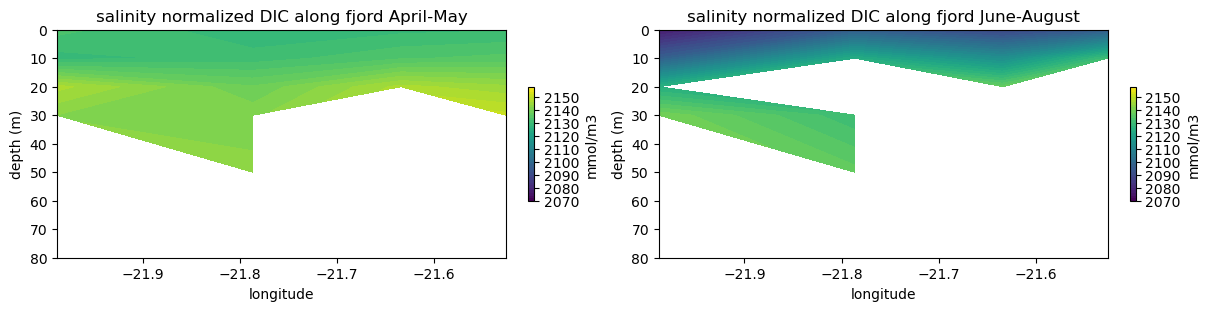

In [14]:
loc = obs['lon'].sel(HV=[1,5,9,10]).isel(depth_bin=0).mean('date').values
depth=obs['depth_bin'].values
levels=np.arange(2070,2160,2)

bins = np.arange(0, 90, 10) 
#depth_bins = xr.DataArray(pd.cut(depth, bins, labels=bins[:-1]), dims="depth", name="binned_depth")

data_alk1=nDIC.sel(HV=[1,5,9,10]).isel(date=slice(0,4)).mean('date')
data_alk2=nDIC.sel(HV=[1,5,9,10]).isel(date=slice(5,9)).mean('date')

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 3), constrained_layout=True)
ax = axarr.flatten()

#c0=ax[0].contourf(loc, data_alk.depth, data_alk.transpose())
c0=ax[0].contourf(loc,data_alk1.depth_bin,data_alk1.transpose(),levels)
plt.colorbar(c0,ax=ax[0], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[0].invert_yaxis()
ax[0].set_title('salinity normalized DIC along fjord April-May')
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('depth (m)')

c0=ax[1].contourf(loc,data_alk2.depth_bin,data_alk2.transpose(),levels)
plt.colorbar(c0,ax=ax[1], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[1].invert_yaxis()
ax[1].set_title('salinity normalized DIC along fjord June-August')
ax[1].set_xlabel('longitude')
ax[1].set_ylabel('depth (m)')

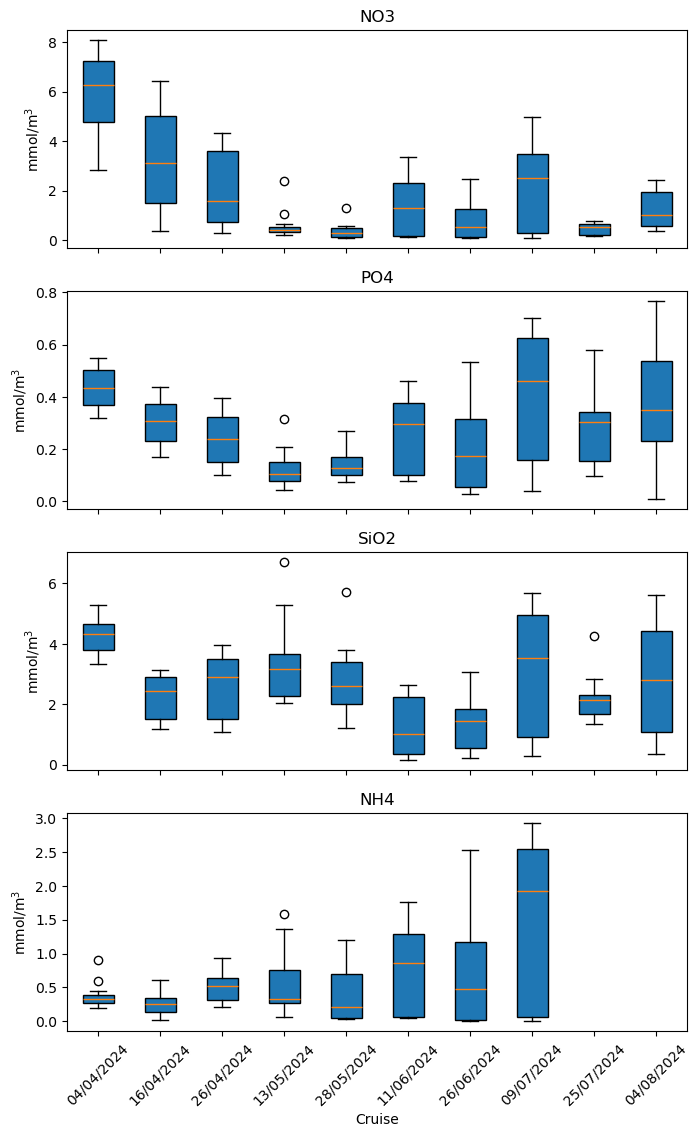

In [15]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define depth levels
levels = np.arange(0, 80)

# Create figure and subplots
fig = plt.figure(figsize=(8, 13))
gs = fig.add_gridspec(4, 1, height_ratios=[1, 1, 1, 1])

# Main map plot
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])



# --- Boxplot Data Preparation ---
def extract_cruise_data(var, depth=None, num_cruises=10):
    """Extracts non-NaN values for a given variable across cruises."""
    cruises = []
    for i in range(num_cruises):
        data = np.hstack(var.isel(date=i) if depth is None else var.isel(date=i, depth=depth))
        cruises.append(data[~np.isnan(data)])
    return cruises

# --- Salinity Normalized DIC Variation ---
ax1.boxplot(extract_cruise_data(obs['NO3']), patch_artist=True)
ax1.set_title('NO3')
ax1.set_ylabel('mmol/m$^3$')
ax1.set_xticklabels([])

# --- Salinity Normalized DIC Variation ---
ax2.boxplot(extract_cruise_data(obs['PO4']), patch_artist=True)
ax2.set_title('PO4')
ax2.set_ylabel('mmol/m$^3$')
ax2.set_xticklabels([])

# --- Total DIC Variation ---
ax3.boxplot(extract_cruise_data(obs['SiO2']), patch_artist=True)
ax3.set_title('SiO2')
ax3.set_ylabel('mmol/m$^3$')
ax3.set_xticklabels([])

# --- Surface-Only Salinity Normalized DIC ---
ax4.boxplot(extract_cruise_data(obs['NH4']), patch_artist=True)
ax4.set_title('NH4')
ax4.set_xlabel('Cruise')
ax4.set_ylabel('mmol/m$^3$')
ax4.set_xticklabels(pd.to_datetime(obs['date'].isel(date=slice(0,10))).strftime('%d/%m/%Y'), rotation=45)

plt.show()


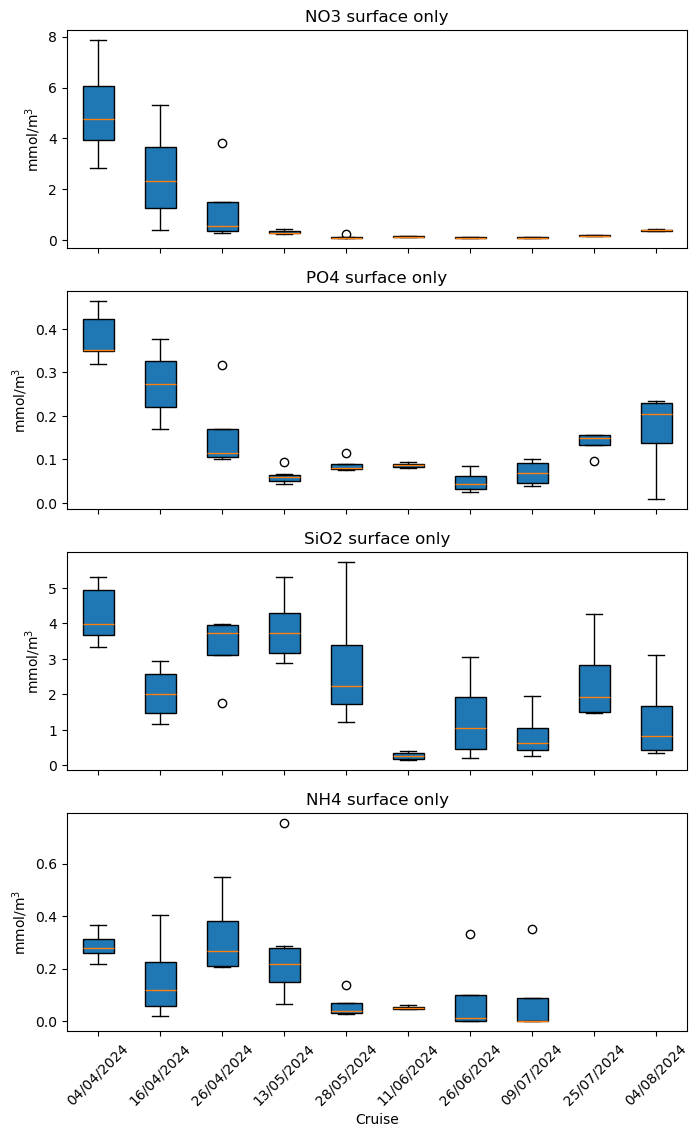

In [21]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define depth levels
levels = np.arange(0, 80)

# Create figure and subplots
fig = plt.figure(figsize=(8, 13))
gs = fig.add_gridspec(4, 1, height_ratios=[1, 1, 1, 1])

# Main map plot
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])



# --- Boxplot Data Preparation ---
def extract_cruise_data(var, depth=0, num_cruises=10):
    """Extracts non-NaN values for a given variable across cruises."""
    cruises = []
    for i in range(num_cruises):
        data = np.hstack(var.isel(date=i) if depth is None else var.isel(date=i, depth_bin=depth))
        cruises.append(data[~np.isnan(data)])
    return cruises

# --- Salinity Normalized DIC Variation ---
ax1.boxplot(extract_cruise_data(obs['NO3']), patch_artist=True)
ax1.set_title('NO3 surface only')
ax1.set_ylabel('mmol/m$^3$')
ax1.set_xticklabels([])

# --- Salinity Normalized DIC Variation ---
ax2.boxplot(extract_cruise_data(obs['PO4']), patch_artist=True)
ax2.set_title('PO4 surface only')
ax2.set_ylabel('mmol/m$^3$')
ax2.set_xticklabels([])

# --- Total DIC Variation ---
ax3.boxplot(extract_cruise_data(obs['SiO2']), patch_artist=True)
ax3.set_title('SiO2 surface only')
ax3.set_ylabel('mmol/m$^3$')
ax3.set_xticklabels([])

# --- Surface-Only Salinity Normalized DIC ---
ax4.boxplot(extract_cruise_data(obs['NH4']), patch_artist=True)
ax4.set_title('NH4 surface only')
ax4.set_xlabel('Cruise')
ax4.set_ylabel('mmol/m$^3$')
ax4.set_xticklabels(pd.to_datetime(obs['date'].isel(date=slice(0,10))).strftime('%d/%m/%Y'), rotation=45)

plt.show()


Text(0, 0.5, 'depth (m)')

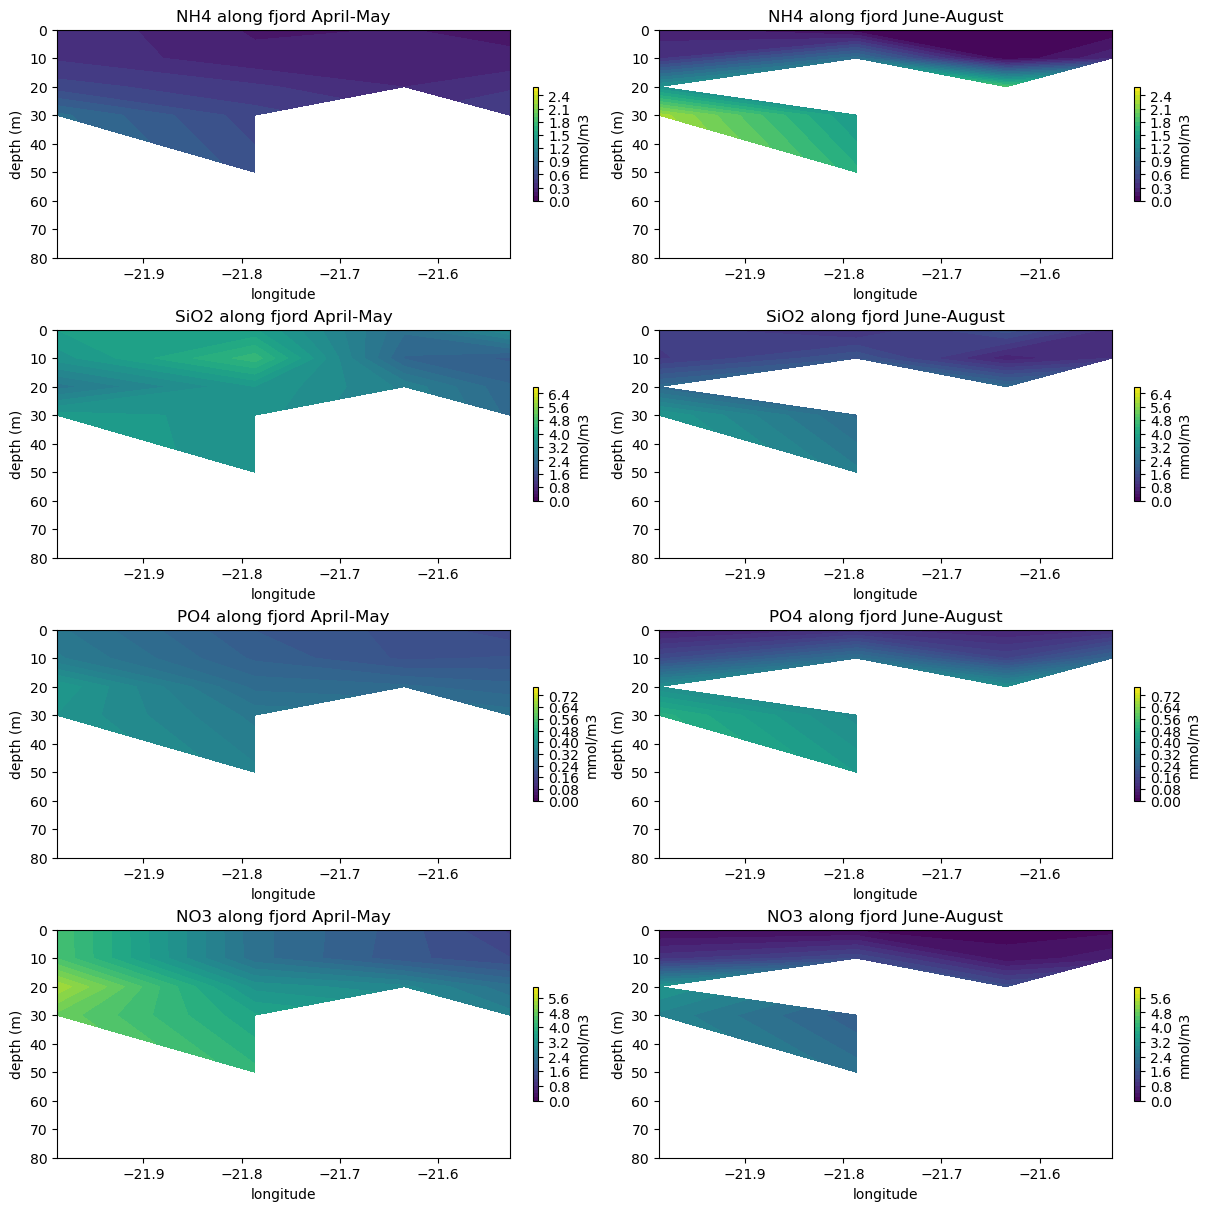

In [22]:
loc = obs['lon'].sel(HV=[1,5,9,10]).isel(depth_bin=0).mean('date').values
depth=obs['depth_bin'].values
levels=np.arange(0,2.7,0.1)

bins = np.arange(0, 90, 10) 
#depth_bins = xr.DataArray(pd.cut(depth, bins, labels=bins[:-1]), dims="depth", name="binned_depth")

data_alk1=obs['NH4'].sel(HV=[1,5,9,10]).isel(date=slice(0,4)).mean('date')
data_alk2=obs['NH4'].sel(HV=[1,5,9,10]).isel(date=slice(5,9)).mean('date')

fig, axarr = plt.subplots(nrows=4, ncols=2, figsize=(6*2, 3*4), constrained_layout=True)
ax = axarr.flatten()

#c0=ax[0].contourf(loc, data_alk.depth, data_alk.transpose())
c0=ax[0].contourf(loc,data_alk1.depth_bin,data_alk1.transpose(),levels)
plt.colorbar(c0,ax=ax[0], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[0].invert_yaxis()
ax[0].set_title('NH4 along fjord April-May')
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('depth (m)')

c0=ax[1].contourf(loc,data_alk2.depth_bin,data_alk2.transpose(),levels)
plt.colorbar(c0,ax=ax[1], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[1].invert_yaxis()
ax[1].set_title('NH4 along fjord June-August')
ax[1].set_xlabel('longitude')
ax[1].set_ylabel('depth (m)')

data_alk1=obs['SiO2'].sel(HV=[1,5,9,10]).isel(date=slice(0,4)).mean('date')
data_alk2=obs['SiO2'].sel(HV=[1,5,9,10]).isel(date=slice(5,9)).mean('date')

levels=np.arange(0,7,0.2)
c0=ax[2].contourf(loc,data_alk1.depth_bin,data_alk1.transpose(),levels)
plt.colorbar(c0,ax=ax[2], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[2].invert_yaxis()
ax[2].set_title('SiO2 along fjord April-May')
ax[2].set_xlabel('longitude')
ax[2].set_ylabel('depth (m)')

c0=ax[3].contourf(loc,data_alk2.depth_bin,data_alk2.transpose(),levels)
plt.colorbar(c0,ax=ax[3], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[3].invert_yaxis()
ax[3].set_title('SiO2 along fjord June-August')
ax[3].set_xlabel('longitude')
ax[3].set_ylabel('depth (m)')

data_alk1=obs['PO4'].sel(HV=[1,5,9,10]).isel(date=slice(0,4)).mean('date')
data_alk2=obs['PO4'].sel(HV=[1,5,9,10]).isel(date=slice(5,9)).mean('date')

levels=np.arange(0,0.8,0.02)
c0=ax[4].contourf(loc,data_alk1.depth_bin,data_alk1.transpose(),levels)
plt.colorbar(c0,ax=ax[4], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[4].invert_yaxis()
ax[4].set_title('PO4 along fjord April-May')
ax[4].set_xlabel('longitude')
ax[4].set_ylabel('depth (m)')

c0=ax[5].contourf(loc,data_alk2.depth_bin,data_alk2.transpose(),levels)
plt.colorbar(c0,ax=ax[5], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[5].invert_yaxis()
ax[5].set_title('PO4 along fjord June-August')
ax[5].set_xlabel('longitude')
ax[5].set_ylabel('depth (m)')

data_alk1=obs['NO3'].sel(HV=[1,5,9,10]).isel(date=slice(0,4)).mean('date')
data_alk2=obs['NO3'].sel(HV=[1,5,9,10]).isel(date=slice(5,9)).mean('date')

levels=np.arange(0,6.4,0.2)
c0=ax[6].contourf(loc,data_alk1.depth_bin,data_alk1.transpose(),levels)
plt.colorbar(c0,ax=ax[6], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[6].invert_yaxis()
ax[6].set_title('NO3 along fjord April-May')
ax[6].set_xlabel('longitude')
ax[6].set_ylabel('depth (m)')

c0=ax[7].contourf(loc,data_alk2.depth_bin,data_alk2.transpose(),levels)
plt.colorbar(c0,ax=ax[7], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[7].invert_yaxis()
ax[7].set_title('NO3 along fjord June-August')
ax[7].set_xlabel('longitude')
ax[7].set_ylabel('depth (m)')